### Required Libraries

In [1]:
from pynq import Overlay
import pynq.lib.dma
from pynq import allocate
from pynq import MMIO
import numpy as np
import time

### C/A Code Generator

In [2]:
"""--------------------------------------------------------------------------------------------------------------------------------------------------------------------------"""
""" CA code generator """
def generateCACode(PRN):
  CAcode=[0]*1023
  g2s=[5,6,7,8,17,18,139,140,141,251,252,254,255,256,257,258,469,470,471,472,473,474,509,512,513,514,515,516,859,860,861,862]

  # generate g1 code
  g1=[0]*1023
  reg1a=[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]

  for i in range(0,1023):
    for j in range(0,10):
      reg1b = reg1a[:]
    g1[i] = reg1b[9]
    reg1a[0] = reg1b[2] * reg1b[9]
    reg1a[1] = reg1b[0]
    reg1a[2] = reg1b[1]
    reg1a[3] = reg1b[2]
    reg1a[4] = reg1b[3]
    reg1a[5] = reg1b[4]
    reg1a[6] = reg1b[5]
    reg1a[7] = reg1b[6]
    reg1a[8] = reg1b[7]
    reg1a[9] = reg1b[8]

  # generate g2 code
  g2_int=[0]*1023
  g2=[0]*1023
  reg2a=[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]

  for i in range(0,1023):
    for j in range(0,10):
      reg2b = reg2a[:]
    g2_int[i] = reg2b[9]
    reg2a[0] = reg2b[1] * reg2b[2] * reg2b[5] * reg2b[7] * reg2b[8] * reg2b[9];
    reg2a[1] = reg2b[0]
    reg2a[2] = reg2b[1]
    reg2a[3] = reg2b[2]
    reg2a[4] = reg2b[3]
    reg2a[5] = reg2b[4]
    reg2a[6] = reg2b[5]
    reg2a[7] = reg2b[6]
    reg2a[8] = reg2b[7]
    reg2a[9] = reg2b[8]

  g2shift = g2s[PRN-1]

  for i in range(0,g2shift):
    g2[i] = g2_int[1023-g2shift+i]
  for i in range(g2shift,1023):
    g2[i] = g2_int[i-g2shift]

  for i in range(0,1023):
    CAcode[i] = -(g1[i] * g2[i])

  return CAcode
"""--------------------------------------------------------------------------------------------------------------------------------------------------------------------------"""

'--------------------------------------------------------------------------------------------------------------------------------------------------------------------------'

### Calculation of PLL and DLL Coefficients

In [3]:
"""--------------------------------------------------------------------------------------------------------------------------------------------------------------------------"""
""" Required Structures and function to calculate PLL and DLL coefficients """
import math

numberOfChannels = 8
samplingFreq = (38.192/2)*pow(10,6)
codeLength = 1023
codeFreqBasis = 1.023*pow(10,6) # constant
codePeriods = 37000
earlyLateSpc = 0.5
PDICode = 0.001
PDICarr = 0.001
dllNoiseBandwidth = 2
dlldampingRatio = 0.7
pllNoiseBandwidth = 25
plldampingRatio = 0.7

# Tracking loop state structure (Here Dictionary)
TrackingLoopState = dict({'status':0,
                          'absolutSample':[0]*10000,
                          'codeFreq':[math.inf]*10000,
                          'carrFreq':[math.inf]*10000,
                          'I_P':[0]*10000,
                          'I_E':[0]*10000,
                          'I_L':[0]*10000,
                          'Q_P':[0]*10000,
                          'Q_E':[0]*10000,
                          'Q_L':[0]*10000,
                          'dllDiscr':[math.inf]*10000,
                          'dllDiscrFilt':[math.inf]*10000,
                          'pllDiscr':[math.inf]*10000,
                          'pllDiscrFilt':[math.inf]*10000,
                          'PRN':0})

# Tracking loop state for all satellites
# TrackLoopAllChannels = dict({1:TrackingLoopState,2:TrackingLoopState,3:TrackingLoopState,4:TrackingLoopState,5:TrackingLoopState,6:TrackingLoopState,7:TrackingLoopState,8:TrackingLoopState})
TrackLoopAllChannels = dict()

# Channel Structure (Here Dictionary)
channelStruct = dict({'PRN':0,
                      'acquiredFreq':0,
                      'codePhase':0,
                      'status':0})

# Channel structure for all satellites
channelStructAllSatellites = dict({1:channelStruct,2:channelStruct,3:channelStruct,4:channelStruct,5:channelStruct,6:channelStruct,7:channelStruct,8:channelStruct})

def calcLoopCoeff(LBW,zeta,k):
  Wn = (8*LBW*zeta)/(4*zeta*zeta+1)
  tau1 = k/(Wn*Wn)
  tau2 = (2*zeta)/Wn
  return tau1,tau2
"""--------------------------------------------------------------------------------------------------------------------------------------------------------------------------"""

'--------------------------------------------------------------------------------------------------------------------------------------------------------------------------'

### Function to update Acquisition Results

In [4]:
"""--------------------------------------------------------------------------------------------------------------------------------------------------------------------------"""
""" Function to update Acquisition results """
acqResults = dict({'carrFreq':[0,0,9549903.08761597,0,0,9544312.19863892,0,0,9550831.86721802,0,0,0,0,0,9549921.29898071,0,0,9548245.85342407,0,0,9547426.34201050,9549693.65692139,0,0,0,9545013.33618164,0,0,0,0,0,0],
                   'codePhase':[0,0,34212,0,0,28202,0,0,4696,0,0,0,0,0,36321,0,0,20724,0,0,13404,6288,0,0,0,26827,0,0,0,0,0,0],
                   'peakMetric':[1.33908659560930,1.57700878025586,3.21475305863745,1.51349695063965,1.95350340687111,4.21641184662159,1.54923194602919,1.02873291215472,3.44180209250678,1.72778254004548,1.86418811975521,1.66189192282642,1.15207289557684,1.44299584694799,12.0872797929917,1.69698437216210,1.36843799823054,9.40016040298789,1.57599974479571,1.31233715274045,14.6171668488047,13.2593297430523,1.15243624009986,1.63988271738061,1.64383197431298,4.32638299149154,1.69058801206827,1.61657618914534,1.99339239391631,1.25122262574452,1.41646256165327,1.48196166299890]})

def preRun(acqResults,numberOfChannels,channelStructAllSatellites):

  sortPeak = []
  for i in range(len(acqResults.get('peakMetric'))):
    peakMetric = acqResults.get('peakMetric')
    sortPeak.append([peakMetric[i],i])
  sortPeak.sort(reverse=True)

  PRN_index = []
  for x in sortPeak:
    PRN_index.append(x[1])

  # Updating channel structure
  nonZeroChannels = 0

  for i in range(len(acqResults.get('peakMetric'))):
    carrFreq = acqResults.get('carrFreq')
    nonZeroChannels += (carrFreq[i]>0)

  for i in range(0,min(numberOfChannels,nonZeroChannels)):
    #channelStructAllSatellites[i+1]['PRN'] = PRN_index[i]
    #channelStructAllSatellites[i+1]['acquiredFreq'] = acqResults['carrFreq'][PRN_index[i]]
    #channelStructAllSatellites[i+1]['codePhase'] = acqResults['codePhase'][PRN_index[i]]
    #channelStructAllSatellites[i+1]['status'] = 1
    channelStructAllSatellites[i+1] = dict({'PRN':PRN_index[i]+1,'acquiredFreq':acqResults['carrFreq'][PRN_index[i]],'codePhase':acqResults['codePhase'][PRN_index[i]],'status':1})
  return channelStructAllSatellites

preRun(acqResults,numberOfChannels,channelStructAllSatellites)
"""--------------------------------------------------------------------------------------------------------------------------------------------------------------------------"""

'--------------------------------------------------------------------------------------------------------------------------------------------------------------------------'

### Signal Record Generation

In [5]:
def read_data():
    file_in = open("signal_record_for_HLS3_Downsampled2.txt", mode="r")
    rawSignal1 = []
    for x in file_in:
        if(len(x)==3):
            rawSignal1.append(int(x[0:2]))
        else:
            rawSignal1.append(int(x[0:1]))

    rawSignal = [] 
    for i in range(1500):
        rawSignal2 = []
        for j in range(19096):
            rawSignal2.append(rawSignal1[19096*i+j])
        rawSignal.append(rawSignal2)
        
    print(type(rawSignal))
    print(len(rawSignal[250]))
    print(len(rawSignal))
    return rawSignal

rawSignal = read_data()
print(rawSignal[1][0:30])
print(len(rawSignal))
print(type(rawSignal))

<class 'list'>
19096
1500
[0, 0, -1, -1, 0, -2, 1, -2, -1, 3, -8, 7, -8, 3, -1, -2, 1, -2, 0, 0, -3, 3, -4, 2, -1, -1, 1, -3, 1, -1]
1500
<class 'list'>


### Signal Record generation for PRN 21

In [6]:
def read_data_PRN21():
    file_in_21 = open("signal_record_for_HLS3_Downsampled2.txt", mode="r")
    rawSignal1_21 = []
    for x in file_in_21:
        if(len(x)==3):
            rawSignal1_21.append(int(x[0:2]))
        else:
            rawSignal1_21.append(int(x[0:1]))

    rawSignal_21 = [] 
    for i in range(1500):
        rawSignal2_21 = []
        for j in range(19096):
            rawSignal2_21.append(rawSignal1_21[19096*i+j+3558])
        rawSignal_21.append(rawSignal2_21)
        
    print(type(rawSignal_21))
    print(len(rawSignal_21[250]))
    print(len(rawSignal_21))
    return rawSignal_21

rawSignal_21 = read_data_PRN21()
print(rawSignal_21[0][0:30])
print(len(rawSignal_21))
print(type(rawSignal_21))

<class 'list'>
19096
1500
[0, 0, -1, -1, -1, 2, -5, 5, -4, 0, 0, -2, 0, 0, -2, 1, -2, -1, 1, -4, 3, -2, -2, 2, -4, 1, -1, -2, 1, -2]
1500
<class 'list'>


In [7]:
print(rawSignal_21[1][0:30])

[0, -3, 1, 0, -3, 2, -2, 0, -1, 1, -1, -1, 2, -3, -1, 2, -4, 0, 2, -5, 4, -4, 1, 2, -5, 4, -3, -2, 2, -2]


### Sin, Cos and Atan LUTs

In [8]:
"""--------------------------------------------------------------------------------------------------------------------------------------------------------------------------"""
""" Sine and Cos LUTs with 360 values """
sinTable = [0.017452, 0.034899, 0.052336, 0.069756, 0.087155, 0.104528, 0.121868, 0.139172, 0.156433, 0.173647, 0.190807, 0.207910, 0.224949, 0.241920, 0.258817, 0.275635,
            0.292369, 0.309014, 0.325566, 0.342017, 0.358365, 0.374604, 0.390728, 0.406733, 0.422615, 0.438368, 0.453987, 0.469468, 0.484806, 0.499996, 0.515034, 0.529915,
            0.544635, 0.559189, 0.573572, 0.587781, 0.601811, 0.615657, 0.629316, 0.642783, 0.656055, 0.669126, 0.681994, 0.694654, 0.707102, 0.719335, 0.731349, 0.743140,
            0.754705, 0.766040, 0.777141, 0.788006, 0.798631, 0.809012, 0.819147, 0.829033, 0.838666, 0.848044, 0.857163, 0.866021, 0.874615, 0.882943, 0.891002, 0.898790,
            0.906304, 0.913542, 0.920501, 0.927180, 0.933577, 0.939689, 0.945515, 0.951053, 0.956302, 0.961259, 0.965923, 0.970293, 0.974368, 0.978145, 0.981625, 0.984806,
            0.987686, 0.990266, 0.992545, 0.994521, 0.996194, 0.997563, 0.998629, 0.999390, 0.999847, 1.000000, 0.999848, 0.999391, 0.998630, 0.997565, 0.996196, 0.994523,
            0.992548, 0.990270, 0.987691, 0.984810, 0.981630, 0.978151, 0.974373, 0.970299, 0.965930, 0.961266, 0.956309, 0.951061, 0.945524, 0.939698, 0.933586, 0.927190,
            0.920511, 0.913552, 0.906315, 0.898801, 0.891014, 0.882956, 0.874628, 0.866034, 0.857176, 0.848058, 0.838680, 0.829048, 0.819163, 0.809028, 0.798647, 0.788022,
            0.777158, 0.766057, 0.754722, 0.743158, 0.731367, 0.719353, 0.707121, 0.694673, 0.682013, 0.669146, 0.656074, 0.642803, 0.629336, 0.615678, 0.601832, 0.587802,
            0.573594, 0.559211, 0.544657, 0.529938, 0.515057, 0.500019, 0.484829, 0.469491, 0.454010, 0.438391, 0.422639, 0.406757, 0.390752, 0.374628, 0.358390, 0.342042,
            0.325590, 0.309040, 0.292394, 0.275660, 0.258842, 0.241945, 0.224975, 0.207936, 0.190833, 0.173673, 0.156459, 0.139198, 0.121894, 0.104554, 0.087181, 0.069782,
            0.052362, 0.034926, 0.017479, 0.000026, -0.017426, -0.034873, -0.052309, -0.069730, -0.087129, -0.104501, -0.121842, -0.139146, -0.156407, -0.173621, -0.190782,
            -0.207884, -0.224924, -0.241894, -0.258792, -0.275610, -0.292344, -0.308989, -0.325541, -0.341993, -0.358341, -0.374579, -0.390704, -0.406709, -0.422591, -0.438344,
            -0.453964, -0.469445, -0.484783, -0.499973, -0.515012, -0.529893, -0.544613, -0.559167, -0.573551, -0.587760, -0.601790, -0.615636, -0.629296, -0.642763, -0.656035,
            -0.669106, -0.681975, -0.694635, -0.707084, -0.719317, -0.731331, -0.743123, -0.754688, -0.766023, -0.777125, -0.787990, -0.798615, -0.808997, -0.819132, -0.829018,
            -0.838652, -0.848030, -0.857149, -0.866008, -0.874603, -0.882931, -0.890990, -0.898778, -0.906293, -0.913531, -0.920491, -0.927170, -0.933567, -0.939680, -0.945507,
            -0.951045, -0.956294, -0.961251, -0.965916, -0.970287, -0.974362, -0.978140, -0.981620, -0.984801, -0.987682, -0.990263, -0.992541, -0.994518, -0.996191, -0.997561,
            -0.998627, -0.999389, -0.999847, -1.000000, -0.999848, -0.999392, -0.998632, -0.997567, -0.996198, -0.994526, -0.992551, -0.990274, -0.987695, -0.984815, -0.981635,
            -0.978156, -0.974379, -0.970306, -0.965937, -0.961273, -0.956317, -0.951070, -0.945532, -0.939707, -0.933596, -0.927200, -0.920522, -0.913563, -0.906326, -0.898813,
            -0.891026, -0.882968, -0.874641, -0.866047, -0.857190, -0.848071, -0.838695, -0.829062, -0.819178, -0.809043, -0.798663, -0.788038, -0.777174, -0.766074, -0.754739,
            -0.743175, -0.731385, -0.719372, -0.707139, -0.694692, -0.682032, -0.669165, -0.656094, -0.642823, -0.629357, -0.615699, -0.601853, -0.587824, -0.573615, -0.559232,
            -0.544679, -0.529960, -0.515079, -0.500042, -0.484852, -0.469514, -0.454034, -0.438415, -0.422663, -0.406782, -0.390776, -0.374652, -0.358414, -0.342067, -0.325615,
            -0.309065, -0.292420, -0.275686, -0.258868, -0.241971, -0.225000, -0.207961, -0.190859, -0.173699, -0.156485, -0.139224, -0.121921, -0.104580, -0.087207, -0.069808,
            -0.052388, -0.034952, -0.017505, -0.000053]

cosTable = [0.999848, 0.999391, 0.998630, 0.997564, 0.996195, 0.994522, 0.992546, 0.990268, 0.987689, 0.984808, 0.981627, 0.978148, 0.974370, 0.970296, 0.965926, 0.961262,
            0.956305, 0.951057, 0.945519, 0.939694, 0.933582, 0.927185, 0.920506, 0.913547, 0.906309, 0.898796, 0.891008, 0.882950, 0.874622, 0.866028, 0.857170, 0.848051,
            0.838673, 0.829040, 0.819155, 0.809020, 0.798639, 0.788014, 0.777150, 0.766048, 0.754714, 0.743149, 0.731358, 0.719344, 0.707111, 0.694663, 0.682003, 0.669136,
            0.656064, 0.642793, 0.629326, 0.615667, 0.601821, 0.587792, 0.573583, 0.559200, 0.544646, 0.529926, 0.515045, 0.500008, 0.484817, 0.469480, 0.453999, 0.438380,
            0.422627, 0.406745, 0.390740, 0.374616, 0.358377, 0.342030, 0.325578, 0.309027, 0.292382, 0.275648, 0.258830, 0.241933, 0.224962, 0.207923, 0.190820, 0.173660,
            0.156446, 0.139185, 0.121881, 0.104541, 0.087168, 0.069769, 0.052349, 0.034912, 0.017465, 0.000013, -0.017439, -0.034886, -0.052322, -0.069743, -0.087142, -0.104515,
            -0.121855, -0.139159, -0.156420, -0.173634, -0.190794, -0.207897, -0.224936, -0.241907, -0.258804, -0.275622, -0.292357, -0.309002, -0.325553, -0.342005, -0.358353,
            -0.374591, -0.390716, -0.406721, -0.422603, -0.438356, -0.453975, -0.469456, -0.484794, -0.499985, -0.515023, -0.529904, -0.544624, -0.559178, -0.573561, -0.587770,
            -0.601800, -0.615647, -0.629306, -0.642773, -0.656045, -0.669116, -0.681984, -0.694644, -0.707093, -0.719326, -0.731340, -0.743131, -0.754696, -0.766031, -0.777133,
            -0.787998, -0.798623, -0.809005, -0.819140, -0.829026, -0.838659, -0.848037, -0.857156, -0.866014, -0.874609, -0.882937, -0.890996, -0.898784, -0.906298, -0.913536,
            -0.920496, -0.927175, -0.933572, -0.939685, -0.945511, -0.951049, -0.956298, -0.961255, -0.965920, -0.970290, -0.974365, -0.978142, -0.981622, -0.984803, -0.987684,
            -0.990265, -0.992543, -0.994519, -0.996192, -0.997562, -0.998628, -0.999390, -0.999847, -1.000000, -0.999848, -0.999392, -0.998631, -0.997566, -0.996197, -0.994525,
            -0.992549, -0.990272, -0.987693, -0.984813, -0.981633, -0.978153, -0.974376, -0.970303, -0.965933, -0.961270, -0.956313, -0.951065, -0.945528, -0.939703, -0.933591,
            -0.927195, -0.920516, -0.913558, -0.906320, -0.898807, -0.891020, -0.882962, -0.874635, -0.866041, -0.857183, -0.848065, -0.838688, -0.829055, -0.819170, -0.809036,
            -0.798655, -0.788030, -0.777166, -0.766065, -0.754731, -0.743167, -0.731376, -0.719363, -0.707130, -0.694682, -0.682023, -0.669155, -0.656084, -0.642813, -0.629347,
            -0.615688, -0.601842, -0.587813, -0.573605, -0.559222, -0.544668, -0.529949, -0.515068, -0.500030, -0.484840, -0.469503, -0.454022, -0.438403, -0.422651, -0.406770,
            -0.390764, -0.374640, -0.358402, -0.342054, -0.325603, -0.309052, -0.292407, -0.275673, -0.258855, -0.241958, -0.224988, -0.207949, -0.190846, -0.173686, -0.156472,
            -0.139211, -0.121908, -0.104567, -0.087194, -0.069795, -0.052375, -0.034939, -0.017492, -0.000039, 0.017413, 0.034860, 0.052296, 0.069717, 0.087116, 0.104488, 0.121829,
            0.139133, 0.156394, 0.173608, 0.190769, 0.207871, 0.224911, 0.241882, 0.258779, 0.275597, 0.292332, 0.308977, 0.325528, 0.341980, 0.358328, 0.374567, 0.390692, 0.406697,
            0.422579, 0.438332, 0.453952, 0.469433, 0.484771, 0.499962, 0.515000, 0.529882, 0.544602, 0.559156, 0.573540, 0.587749, 0.601779, 0.615626, 0.629285, 0.642753, 0.656025,
            0.669097, 0.681965, 0.694625, 0.707074, 0.719308, 0.731322, 0.743114, 0.754679, 0.766014, 0.777116, 0.787982, 0.798607, 0.808989, 0.819125, 0.829011, 0.838645, 0.848023,
            0.857143, 0.866001, 0.874596, 0.882925, 0.890984, 0.898773, 0.906287, 0.913525, 0.920486, 0.927165, 0.933563, 0.939676, 0.945502, 0.951041, 0.956290, 0.961248, 0.965913,
            0.970283, 0.974359, 0.978137, 0.981617, 0.984799, 0.987680, 0.990261, 0.992540, 0.994516, 0.996190, 0.997560, 0.998627, 0.999389, 0.999847, 1.000000]

atanTable = [-1.548578, -1.548454, -1.548328, -1.548201, -1.548073, -1.547943, -1.547812, -1.547679, -1.547545, -1.547409, -1.547271, -1.547132, -1.546991, -1.546849, -1.546705,
             -1.546559, -1.546411, -1.546261, -1.546110, -1.545957, -1.545802, -1.545644, -1.545485, -1.545324, -1.545161, -1.544996, -1.544828, -1.544658, -1.544487, -1.544312,
             -1.544136, -1.543957, -1.543776, -1.543592, -1.543406, -1.543217, -1.543026, -1.542832, -1.542635, -1.542435, -1.542233, -1.542027, -1.541819, -1.541608, -1.541393,
             -1.541175, -1.540954, -1.540730, -1.540503, -1.540271, -1.540037, -1.539799, -1.539556, -1.539311, -1.539061, -1.538807, -1.538549, -1.538287, -1.538021, -1.537751,
             -1.537475, -1.537196, -1.536911, -1.536622, -1.536327, -1.536028, -1.535723, -1.535413, -1.535097, -1.534776, -1.534449, -1.534116, -1.533776, -1.533431, -1.533078,
             -1.532720, -1.532354, -1.531981, -1.531601, -1.531213, -1.530818, -1.530414, -1.530003, -1.529583, -1.529154, -1.528716, -1.528269, -1.527812, -1.527345, -1.526869,
             -1.526381, -1.525883, -1.525373, -1.524852, -1.524318, -1.523772, -1.523213, -1.522641, -1.522054, -1.521454, -1.520838, -1.520207, -1.519559, -1.518895, -1.518213,
             -1.517513, -1.516795, -1.516057, -1.515298, -1.514518, -1.513716, -1.512890, -1.512041, -1.511166, -1.510264, -1.509335, -1.508378, -1.507389, -1.506369, -1.505316,
             -1.504228, -1.503103, -1.501940, -1.500736, -1.499489, -1.498197, -1.496857, -1.495467, -1.494024, -1.492525, -1.490966, -1.489344, -1.487655, -1.485895, -1.484058,
             -1.482140, -1.480136, -1.478040, -1.475845, -1.473543, -1.471128, -1.468590, -1.465919, -1.463106, -1.460139, -1.457004, -1.453688, -1.450173, -1.446441, -1.442473,
             -1.438245, -1.433730, -1.428899, -1.423718, -1.418147, -1.412141, -1.405648, -1.398606, -1.390943, -1.382575, -1.373401, -1.363300, -1.352127, -1.339706, -1.325818,
             -1.310194, -1.292497, -1.272297, -1.249046, -1.222025, -1.190290, -1.152572, -1.107149, -1.051650, -0.982794, -0.896055, -0.785398, -0.643501, -0.463648, -0.244979,
             0.000000, 0.244979, 0.463648, 0.643501, 0.785398, 0.896055, 0.982794, 1.051650, 1.107149, 1.152572, 1.190290, 1.222025, 1.249046, 1.272297, 1.292497, 1.310194, 1.325818,
             1.339706, 1.352127, 1.363300, 1.373401, 1.382575, 1.390943, 1.398606, 1.405648, 1.412141, 1.418147, 1.423718, 1.428899, 1.433730, 1.438245, 1.442473, 1.446441, 1.450173,
             1.453688, 1.457004, 1.460139, 1.463106, 1.465919, 1.468590, 1.471128, 1.473543, 1.475845, 1.478040, 1.480136, 1.482140, 1.484058, 1.485895, 1.487655, 1.489344, 1.490966,
             1.492525, 1.494024, 1.495467, 1.496857, 1.498197, 1.499489, 1.500736, 1.501940, 1.503103, 1.504228, 1.505316, 1.506369, 1.507389, 1.508378, 1.509335, 1.510264, 1.511166,
             1.512041, 1.512890, 1.513716, 1.514518, 1.515298, 1.516057, 1.516795, 1.517513, 1.518213, 1.518895, 1.519559, 1.520207, 1.520838, 1.521454, 1.522054, 1.522641, 1.523213,
             1.523772, 1.524318, 1.524852, 1.525373, 1.525883, 1.526381, 1.526869, 1.527345, 1.527812, 1.528269, 1.528716, 1.529154, 1.529583, 1.530003, 1.530414, 1.530818, 1.531213,
             1.531601, 1.531981, 1.532354, 1.532720, 1.533078, 1.533431, 1.533776, 1.534116, 1.534449, 1.534776, 1.535097, 1.535413, 1.535723, 1.536028, 1.536327, 1.536622, 1.536911,
             1.537196, 1.537475, 1.537751, 1.538021, 1.538287, 1.538549, 1.538807, 1.539061, 1.539311, 1.539556, 1.539799, 1.540037, 1.540271, 1.540503, 1.540730, 1.540954, 1.541175,
             1.541393, 1.541608, 1.541819, 1.542027, 1.542233, 1.542435, 1.542635, 1.542832, 1.543026, 1.543217, 1.543406, 1.543592, 1.543776, 1.543957, 1.544136, 1.544312, 1.544487,
             1.544658, 1.544828, 1.544996, 1.545161, 1.545324, 1.545485, 1.545644, 1.545802, 1.545957, 1.546110, 1.546261, 1.546411, 1.546559, 1.546705, 1.546849, 1.546991, 1.547132,
             1.547271, 1.547409, 1.547545, 1.547679, 1.547812, 1.547943, 1.548073, 1.548201, 1.548328, 1.548454] 
"""--------------------------------------------------------------------------------------------------------------------------------------------------------------------------"""

'--------------------------------------------------------------------------------------------------------------------------------------------------------------------------'

### Tracking Main Block

In [9]:
"""--------------------------------------------------------------------------------------------------------------------------------------------------------------------------"""
def tracking_block(rawSignal,loopCount,channelNr,channelStructAllSatellites,trackingLoopState):

    # calculate DLL coefficients
    [tau1code,tau2code] = calcLoopCoeff(dllNoiseBandwidth,dlldampingRatio,1)

    # calculate PLL coefficients
    [tau1carr,tau2carr] = calcLoopCoeff(pllNoiseBandwidth,plldampingRatio,0.25)

    #print(tau1code)
    #print(tau2code)
    #print(tau1carr)
    #print(tau2carr)

    print(channelStructAllSatellites[channelNr].get('PRN'))

    caCode = generateCACode(channelStructAllSatellites[channelNr].get('PRN'))

    # CA code preparation for early and late versions
    caCode_v2 = []
    for i in range(0,1025):
        if(i==0):
            caCode_v2.append(caCode[0])
        elif(i>=1 and i<=1023):
            caCode_v2.append(caCode[i-1])
        else:
            caCode_v2.append(caCode[1022])

    # Performing various initializations and update of different signals
    
    codeFreq = 1.023*pow(10,6) if (loopCount==0) else trackingLoopState[0][loopCount-1]
    carrFreq = channelStructAllSatellites[channelNr].get('acquiredFreq') if (loopCount==0) else trackingLoopState[1][loopCount-1]
    oldCodeError = 0.0 if (loopCount==0) else trackingLoopState[2][loopCount-1]
    oldCodeNco = 0.0 if (loopCount==0) else trackingLoopState[3][loopCount-1]
    oldCarrError = 0.0 if (loopCount==0) else trackingLoopState[4][loopCount-1]
    oldCarrNco = 0.0 if (loopCount==0) else trackingLoopState[5][loopCount-1]
    remCodePhase = 0.0 if (loopCount==0) else trackingLoopState[12][loopCount-1]
    remCarrPhase = 0.0 if (loopCount==0) else trackingLoopState[13][loopCount-1]
    
    carrFreqBasis = channelStructAllSatellites[channelNr].get('acquiredFreq')
    codeFreqBasis = 1.023*pow(10,6)
            
    codePhaseStep = codeFreq / samplingFreq
    blkSize = math.ceil((codeLength - remCodePhase)/codePhaseStep)
    blkSize = blkSize if (blkSize==len(rawSignal)) else len(rawSignal)
    print(blkSize)
    print(len(rawSignal))
    # Set up code phase tracking information

    # Early code vector
    tcode = np.arange((remCodePhase-earlyLateSpc),((blkSize-1)*codePhaseStep+remCodePhase-earlyLateSpc)+codePhaseStep,codePhaseStep)
    #print(tcode[0:100])
    tcode2 = [math.ceil(i+1) if i<1024 else 1025 for i in tcode]
    #print(tcode2[38100:38192])
    earlyCode = []
    for i in range(len(tcode2)):
        earlyCode.append(caCode_v2[tcode2[i]-1])
    #print(earlyCode[38100:38192])
    file_out = open("early vector_for_HLS3.txt","w")
    for i in range(len(earlyCode)):
      file_out.write("{}\n".format(tcode2[i]))
    
                
    # Late code vector
    tcode = np.arange((remCodePhase+earlyLateSpc),((blkSize-1)*codePhaseStep+remCodePhase+earlyLateSpc)+codePhaseStep,codePhaseStep)
    tcode2 = [math.ceil(i+1) if i<1024 else 1025 for i in tcode]
    #print(tcode2)
    lateCode = []
    for i in range(len(tcode2)):
        lateCode.append(caCode_v2[tcode2[i]-1])
    file_out = open("late vector_for_HLS3.txt","w")
    for i in range(len(lateCode)):
      file_out.write("{}\n".format(tcode2[i]))

    # Prompt code vector
    tcode = np.arange(remCodePhase,((blkSize-1)*codePhaseStep+remCodePhase)+codePhaseStep,codePhaseStep)
    tcode2 = [math.ceil(i+1) if i<1024 else 1025 for i in tcode]
    promptCode = []
    for i in range(len(tcode2)):
        promptCode.append(caCode_v2[tcode2[i]-1])
    file_out = open("prompt vector_for_HLS3.txt","w")
    for i in range(len(promptCode)):
      file_out.write("{}\n".format(tcode2[i]))

    remCodePhase = (tcode[blkSize-1]+codePhaseStep)-1023

    # generate the carrier frequency to mix the signal to baseband
    time = []
    trigarg = []
    for i in range(0,blkSize+1):
        time.append(i/samplingFreq)
        trigarg.append((2.0*math.pi*carrFreq*time[i]) + remCarrPhase)

    # quotient = trigarg[blkSize] / (2.0*math.pi)
    remCarrPhase = trigarg[blkSize] % (2.0*math.pi)
    print(remCarrPhase)

    # Edited for sine and cosine tables
    carrCos = []
    carrSin = []
    for i in range(blkSize+1):
        carrCos.append(cosTable[int(trigarg[i]*180/math.pi)%360]);
        carrSin.append(sinTable[int(trigarg[i]*180/math.pi)%360]);
    # Editing ends here
    #print(carrCos[0:100])

    # generating accumulated values
    qBasebandSignal = []
    iBasebandSignal = []
    for i in range(len(rawSignal)):
        qBasebandSignal.append(carrCos[i]*rawSignal[i])
        iBasebandSignal.append(carrSin[i]*rawSignal[i])

    # early correlation, late correlation and prompt correlation
    I_E = 0
    I_P = 0
    I_L = 0
    Q_P = 0
    Q_L = 0
    Q_E = 0
    for i in range(len(rawSignal)):
        I_E += earlyCode[i] * iBasebandSignal[i]
        I_P += promptCode[i] * iBasebandSignal[i]
        I_L += lateCode[i] * iBasebandSignal[i]
        Q_E += earlyCode[i] * qBasebandSignal[i]
        Q_P += promptCode[i] * qBasebandSignal[i]
        Q_L += lateCode[i] * qBasebandSignal[i]

    #print(I_E)
    #print(I_P)
    #print(I_L)
    #print(Q_E)
    #print(Q_P)
    #print(Q_L)
            
    # calculate PLL error and NCO update
    index = (int((Q_P//I_P)) % 45) if (Q_P/I_P >0) else (int((Q_P//I_P)) % 45) - 45
    carrError = atanTable[index*4+180]/(2.0*math.pi)
    #print(carrError)
    carrNco = oldCarrNco + (tau2carr/tau1carr) * (carrError-oldCarrError) + carrError * (PDICarr/tau1carr)
    #print(carrNco)
    #oldCarrNco = carrNco
    #oldCarrError = carrError

    carrFreq = carrFreqBasis + carrNco

    # claculate DLL error and NCO update
      
    codeError = (math.sqrt(pow(I_E,2)+pow(Q_E,2)) - math.sqrt(pow(I_L,2)+pow(Q_L,2))) / (math.sqrt(pow(I_E,2)+pow(Q_E,2)) + math.sqrt(pow(I_L,2)+pow(Q_L,2)))
    #print(codeError)
    codeNco = oldCodeNco + (tau2code/tau1code) * (codeError - oldCodeError) + codeError * (PDICode/tau1code)
    #print(codeNco)
    #oldCodeNco = codeNco
    #oldCodeError = codeError

    codeFreq = codeFreqBasis - codeNco

    print(list([codeFreq,carrFreq,codeError,codeNco,carrError,carrNco,I_E,I_P,I_L,Q_E,Q_P,Q_L,remCodePhase,remCarrPhase]))
    # return the following outputs
    return codeFreq,carrFreq,codeError,codeNco,carrError,carrNco,I_E,I_P,I_L,Q_E,Q_P,Q_L,remCodePhase,remCarrPhase
"""--------------------------------------------------------------------------------------------------------------------------------------------------------------------------"""

'--------------------------------------------------------------------------------------------------------------------------------------------------------------------------'

### Tracking Main Function

In [10]:
"""--------------------------------------------------------------------------------------------------------------------------------------------------------------------------"""
""" Tracking main function """
import matplotlib.pyplot as plt
import numpy as np

def tracking_main(rawSignal,channelNr,channelStructAllSatellites):
    # Go for processing if PRN is non zero
    results_out = open("results_out_2.csv","w")
    if(channelStructAllSatellites[channelNr].get('PRN')!=0):

        # performing various initializations
        # initializing carrier frequency
        carrFreqBasis = channelStructAllSatellites[channelNr].get('acquiredFreq')
        #print(carrFreqBasis)

        codeErrorList =[]
        codeNcoList = []
        carrErrorList = []
        carrNcoList = []
        codeFreqList=[]
        carrFreqList=[]
        I_EList = []
        I_PList = []
        I_LList = []
        Q_EList = []
        Q_PList = []
        Q_LList = []
        remCodePhaseList = []
        remCarrPhaseList = []
        trackingLoopState=[codeFreqList,carrFreqList,codeErrorList,codeNcoList,carrErrorList,carrNcoList,I_EList,I_PList,I_LList,Q_EList,Q_PList,Q_LList,remCodePhaseList,remCarrPhaseList]
        start_time = time.time()
        for loopCount in range(1500):
            results = list(tracking_block(rawSignal[loopCount],loopCount,channelNr,channelStructAllSatellites,trackingLoopState))
            # Recording various measures
            codeFreqList.append(results[0])
            carrFreqList.append(results[1])
            codeErrorList.append(results[2])
            codeNcoList.append(results[3])
            carrErrorList.append(results[4])
            carrNcoList.append(results[5])
            I_EList.append(results[6])
            I_PList.append(results[7])
            I_LList.append(results[8])
            Q_EList.append(results[9])
            Q_PList.append(results[10])
            Q_LList.append(results[11])
            remCodePhaseList.append(results[12])
            remCarrPhaseList.append(results[13])
            results_out.write("{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13}\n".format(results[0],results[1],results[2],results[3],results[4],results[5],results[6],results[7],results[8],results[9],results[10],results[11],results[12],results[13]))
        TrackLoopAllChannels[channelNr] = dict({'PRN':channelStructAllSatellites[channelNr].get('PRN'),'carrFreq':carrFreqList,'codeFreq':codeFreqList,'dllDiscr':codeErrorList,'dllDiscrFilt':codeNcoList,'pllDiscr':carrErrorList,'pllDiscrFilt':carrNcoList,'I_E':I_EList,'I_P':I_PList,'I_L':I_LList,'Q_E':Q_EList,'Q_P':Q_PList,'Q_L':Q_LList})
        
        stop_time = time.time()
        SW_execution_time = stop_time - start_time
        print("Total time taken is {} ms".format(SW_execution_time*1000))
 
 
        # Define X and Y variable data
        x = np.arange(1500)
        y = np.array(I_PList)
 
        plt.plot(x, y)
        plt.xlabel("X-axis")  # add X-axis label
        plt.ylabel("Y-axis")  # add Y-axis label
        plt.title("Navigation Data Bits SW Testing")  # add title
        plt.show()
    return TrackLoopAllChannels[channelNr]
"""--------------------------------------------------------------------------------------------------------------------------------------------------------------------------"""

'--------------------------------------------------------------------------------------------------------------------------------------------------------------------------'

### Calling Tracking Main Function

21
19096
19096
2.6787858562060975
[1023000.0370278193, 9547474.590116635, -0.006971104686615568, -0.037027819458870535, 0.17620823608924882, 48.24810613444479, -1308.9673460000038, -2165.2810599999893, -1062.9108239999966, -2880.8709999999905, -5062.119273999998, -3027.5681760000034, 0.0, 2.6787858562060975]
21
19096
19096
5.660723503988713
[1023000.0334141137, 9547476.16685213, -0.006271974274396546, -0.03341411379514944, 0.17620823608924882, 49.82484162903449, -1481.6340109999965, -2234.08872099999, -1496.3765530000078, -3169.9989799999953, -5720.7297020000115, -3211.8623000000002, 3.702781941683497e-05, 5.660723503988713]
21
19096
19096
2.36938276588009
[1023000.4111100545, 9547477.743587624, -0.07736263001390395, -0.41111005460682226, 0.17620823608924882, 51.401577123624186, -685.8488139999977, -2400.633929999988, -1736.800551999998, -2683.3634690000185, -4990.25332899999, -2728.159943000005, 7.04419330759265e-05, 2.36938276588009]
21
19096
19096
5.371134256242378
[1023000.09876666

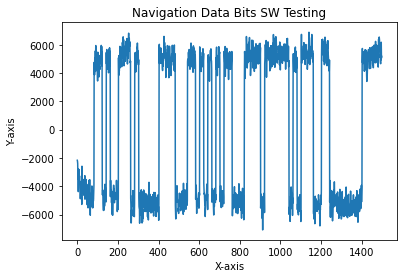

22
19096
19096
4.358374976703949
[1023000.7150275381, 9549635.879506085, -0.13461586169056758, -0.7150275382535655, -0.2110104883402105, -57.77741530630234, -495.0552990000007, -1144.4145269999956, -1338.6942609999999, 1783.6448530000157, 4030.1565390000023, 2024.3643789999903, 0.0, 4.358374976703949]
22
19096
19096
2.0705384392955892
[1023000.4732774766, 9549657.54215241, -0.08873953390056108, -0.47327747669865233, -0.12499997399448842, -36.11476898027872, -2428.1898180000003, -4012.6469180000076, -2594.687642000011, 1041.108746000004, 3370.4981220000213, 1797.5712240000064, 0.0007150275380354287, 2.0705384392955892]
22
19096
19096
6.201997630165302
[1022999.913064844, 9549656.423635477, 0.016969029402609137, 0.08693515591703906, -0.12499997399448842, -37.233285913392294, -2625.378579999988, -4707.884955999984, -2677.3584299999966, 1061.3824850000017, 1975.0570109999933, 569.738393000002, 0.0011883050145797824, 6.201997630165302]
22
19096
19096
4.043243664704889
[1022999.8947951605, 9

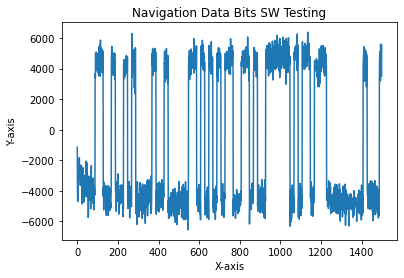

In [13]:
"""--------------------------------------------------------------------------------------------------------------------------------------------------------------------------"""

""" Calling tracking main function """
for channelNr in range(1,3):
    rawSignal_in = rawSignal_21 if (channelNr==1) else rawSignal
    tracking_main(rawSignal_in,channelNr,channelStructAllSatellites)

#print("PLL Discriminator Error values are")

#print(TrackLoopAllChannels[1]['pllDiscr'])
#print(TrackLoopAllChannels[2]['pllDiscr'])
#print(TrackLoopAllChannels[3]['pllDiscr'])
#print(TrackLoopAllChannels[4]['pllDiscr'])
#print(TrackLoopAllChannels[5]['pllDiscr'])
#print(TrackLoopAllChannels[6]['pllDiscr'])
#print(TrackLoopAllChannels[7]['pllDiscr'])
#print(TrackLoopAllChannels[8]['pllDiscr'])

#print("PLL Discriminator NCO values are")

#print(TrackLoopAllChannels[1]['pllDiscrFilt'])
#print(TrackLoopAllChannels[2]['pllDiscrFilt'])
#print(TrackLoopAllChannels[3]['pllDiscrFilt'])
#print(TrackLoopAllChannels[4]['pllDiscrFilt'])
#print(TrackLoopAllChannels[5]['pllDiscrFilt'])
#print(TrackLoopAllChannels[6]['pllDiscrFilt'])
#print(TrackLoopAllChannels[7]['pllDiscrFilt'])
#print(TrackLoopAllChannels[8]['pllDiscrFilt'])

#print("DLL Discriminator Error values are")

#print(TrackLoopAllChannels[1]['dllDiscr'])
#print(TrackLoopAllChannels[2]['dllDiscr'])
#print(TrackLoopAllChannels[3]['dllDiscr'])
#print(TrackLoopAllChannels[4]['dllDiscr'])
#print(TrackLoopAllChannels[5]['dllDiscr'])
#print(TrackLoopAllChannels[6]['dllDiscr'])
#print(TrackLoopAllChannels[7]['dllDiscr'])
#print(TrackLoopAllChannels[8]['dllDiscr'])

#print("DLL Discriminator NCO values are")

#print(TrackLoopAllChannels[1]['dllDiscrFilt'])
#print(TrackLoopAllChannels[2]['dllDiscrFilt'])
#print(TrackLoopAllChannels[3]['dllDiscrFilt'])
#print(TrackLoopAllChannels[4]['dllDiscrFilt'])
#print(TrackLoopAllChannels[5]['dllDiscrFilt'])
#print(TrackLoopAllChannels[6]['dllDiscrFilt'])
#print(TrackLoopAllChannels[7]['dllDiscrFilt'])
#print(TrackLoopAllChannels[8]['dllDiscrFilt'])

### Hardware Testing

In [11]:
from pynq import Overlay
import pynq.lib.dma
from pynq import allocate
from pynq import MMIO
import numpy as np
import time
import math
import struct

In [14]:
base_addr1 = 0x00A0020000
addr_range1 = 0x10000
mmio1 = MMIO(base_addr1, addr_range1)

base_addr2 = 0x00A0030000
addr_range2 = 0x10000
mmio2 = MMIO(base_addr2, addr_range2) 

overlay = Overlay('./track_ms_wrapper.bit')

In [16]:
overlay?

In [17]:
dma1 = overlay.axi_dma_0
dma1_send = dma1.sendchannel
dma1_recv = dma1.recvchannel

dma2 = overlay.axi_dma_1
dma2_send = dma2.sendchannel
dma2_recv = dma2.recvchannel

In [18]:
hls_ip1 = overlay.tracking_block_0
hls_ip2 = overlay.tracking_block_1

In [19]:
hls_ip1.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0),
  loopCount = Register(loopCount=write-only),
  channelNr = Register(channelNr=write-only),
  Memory_PRN_index = Register(value=0),
  Memory_acquiredFreq = Register(value=0),
  Memory_codePhase = Register(value=0)
}

In [20]:
hls_ip2.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0),
  loopCount = Register(loopCount=write-only),
  channelNr = Register(channelNr=write-only),
  Memory_PRN_index = Register(value=0),
  Memory_acquiredFreq = Register(value=0),
  Memory_codePhase = Register(value=0)
}

In [21]:
dma1.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=0, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=0),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=0),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SG

In [22]:
dma2.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=0, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=0),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=0),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SG

In [23]:
# Writing PRN values to base addresses
mmio1.write(0x20,21)
mmio1.write(0x24,22)
mmio1.write(0x28,15)
mmio1.write(0x2c,18)
mmio1.write(0x30,26)
mmio1.write(0x34,6)
mmio1.write(0x38,9)
mmio1.write(0x3c,3)

# Writing Acquired frequency
mmio1.write(0x40,0x4AF1C001)
mmio1.write(0x44,0x416235D4)
mmio1.write(0x48,0xB5058002)
mmio1.write(0x4c,0x416236EF)
mmio1.write(0x50,0x29913FFE)
mmio1.write(0x54,0x4162370C)
mmio1.write(0x58,0xBB4F3FFF)
mmio1.write(0x5c,0x4162363A)
mmio1.write(0x60,0xAAC20000)
mmio1.write(0x64,0x416234A6)
mmio1.write(0x68,0x065B4002)
mmio1.write(0x6c,0x4162344F)
mmio1.write(0x70,0xFBC04001)
mmio1.write(0x74,0x4162377D)
mmio1.write(0x78,0xE2CDC002)
mmio1.write(0x7c,0x41623709)

# Writing code Phases
mmio1.write(0x80,13404)
mmio1.write(0x84,6288)
mmio1.write(0x88,36321)
mmio1.write(0x8c,20724)
mmio1.write(0x90,26827)
mmio1.write(0x94,28202)
mmio1.write(0x98,4696)
mmio1.write(0x9c,34212)


# Writing PRN values to base addresses
mmio2.write(0x20,21)
mmio2.write(0x24,22)
mmio2.write(0x28,15)
mmio2.write(0x2c,18)
mmio2.write(0x30,26)
mmio2.write(0x34,6)
mmio2.write(0x38,9)
mmio2.write(0x3c,3)

# Writing Acquired frequency
mmio2.write(0x40,0x4AF1C001)
mmio2.write(0x44,0x416235D4)
mmio2.write(0x48,0xB5058002)
mmio2.write(0x4c,0x416236EF)
mmio2.write(0x50,0x29913FFE)
mmio2.write(0x54,0x4162370C)
mmio2.write(0x58,0xBB4F3FFF)
mmio2.write(0x5c,0x4162363A)
mmio2.write(0x60,0xAAC20000)
mmio2.write(0x64,0x416234A6)
mmio2.write(0x68,0x065B4002)
mmio2.write(0x6c,0x4162344F)
mmio2.write(0x70,0xFBC04001)
mmio2.write(0x74,0x4162377D)
mmio2.write(0x78,0xE2CDC002)
mmio2.write(0x7c,0x41623709)

# Writing code Phases
mmio2.write(0x80,13404)
mmio2.write(0x84,6288)
mmio2.write(0x88,36321)
mmio2.write(0x8c,20724)
mmio2.write(0x90,26827)
mmio2.write(0x94,28202)
mmio2.write(0x98,4696)
mmio2.write(0x9c,34212)

In [24]:
hls_ip1.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0),
  loopCount = Register(loopCount=write-only),
  channelNr = Register(channelNr=write-only),
  Memory_PRN_index = Register(value=21),
  Memory_acquiredFreq = Register(value=4711387346089656321),
  Memory_codePhase = Register(value=13404)
}

In [25]:
hls_ip2.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0),
  loopCount = Register(loopCount=write-only),
  channelNr = Register(channelNr=write-only),
  Memory_PRN_index = Register(value=21),
  Memory_acquiredFreq = Register(value=4711387346089656321),
  Memory_codePhase = Register(value=13404)
}

[1022999.9137064235, 9547474.59011771, 0.016246204316328183, 0.08629357651295141, 0.17620823687487236, 48.248107210683635, -1337.7224133676154, -3052.458428838182, -2195.145712066389, -5066.89302741267, -1065.3465331584575, -3045.184242070606, 2.580691216280684e-11, 2.6787858562060975]
[1023000.6411943801, 9549635.879507553, -0.12071553095162135, -0.6411943801547388, -0.21101047920779223, -57.777413836929995, -496.7753963965788, 1834.8305528607034, -1162.5669721658069, 4047.2572074664786, -1313.415714676672, 2035.9408718175255, 2.580691216280684e-11, 4.358374976703949]
[1023000.2058442453, 9547476.16685324, -0.03879740095293, -0.20584424523195616, 0.17620823687487236, 49.82484273998385, -1517.5462122296394, -3020.364001233954, -2234.255089176024, -5776.199407067296, -1541.7780850617983, -3311.739560925792, -8.629357364497992e-05, 5.660723510733526]
[1023000.4730785075, 9549657.542151567, -0.08873953660349285, -0.47307850751392677, -0.12499997501932036, -36.11476982319215, -2428.1898064

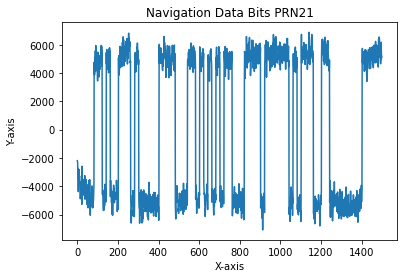

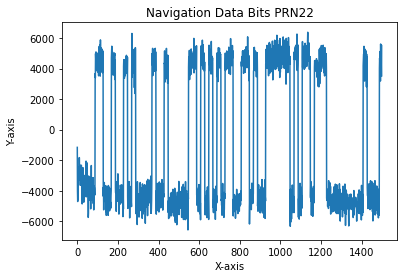

Hardware Execution time is 2487.8108501434326ms


In [28]:
total_hw_execution_time = 0

HW_results1 = open("HW_results1.csv","w")

HW_results2 = open("HW_results2.csv","w")

I_P_list1 = []
I_L_list1 = []
I_E_list1 = []
Q_P_list1 = []
Q_L_list1 = []
Q_E_list1 = []

I_P_list2 = []
I_L_list2 = []
I_E_list2 = []
Q_P_list2 = []
Q_L_list2 = []
Q_E_list2 = []
    
mmio1.write(0x18,1)
mmio2.write(0x18,2)

for loopCount in range(1500):
    
    mmio1.write(0x10,loopCount)
    mmio2.write(0x10,loopCount)

    mmio1.write(0x0,81)
    mmio2.write(0x0,81)

    in_buffer1 = allocate(shape=(19096,),dtype=np.intc)
    out_buffer1 = allocate(shape=(14,),dtype=np.double)

    in_buffer2 = allocate(shape=(19096,),dtype=np.intc)
    out_buffer2 = allocate(shape=(14,),dtype=np.double)
    
    for i in range(19096):
        in_buffer1[i] = rawSignal_21[loopCount][i]
        in_buffer2[i] = rawSignal[loopCount][i]
    
    start_time = time.time()
    
    dma1_send.transfer(in_buffer2)
    dma2_send.transfer(in_buffer1)

    dma1_recv.transfer(out_buffer2)
    dma2_recv.transfer(out_buffer1)
    dma1_recv.wait()
    dma2_recv.wait()

    stop_time = time.time()

    total_hw_execution_time += (stop_time - start_time)

    print(list(out_buffer1))
    print(list(out_buffer2))

    I_P_list1.append(list(out_buffer1)[8])
    I_E_list1.append(list(out_buffer1)[6])
    I_L_list1.append(list(out_buffer1)[10])
    Q_P_list1.append(list(out_buffer1)[9])
    Q_E_list1.append(list(out_buffer1)[7])
    Q_L_list1.append(list(out_buffer1)[11])
    
    I_P_list2.append(list(out_buffer2)[8])
    I_E_list2.append(list(out_buffer2)[6])
    I_L_list2.append(list(out_buffer2)[10])
    Q_P_list2.append(list(out_buffer2)[9])
    Q_E_list2.append(list(out_buffer2)[7])
    Q_L_list2.append(list(out_buffer2)[11])

    HW_results1.write("{0},{1},{2},{3},{4},{5}\n".format(list(out_buffer1)[8],list(out_buffer1)[9],list(out_buffer1)[6],list(out_buffer1)[7],list(out_buffer1)[10],list(out_buffer1)[11]))
    HW_results2.write("{0},{1},{2},{3},{4},{5}\n".format(list(out_buffer2)[8],list(out_buffer2)[9],list(out_buffer2)[6],list(out_buffer2)[7],list(out_buffer2)[10],list(out_buffer2)[11]))
    
    
    in_buffer1.close()
    out_buffer1.close()
    in_buffer2.close()
    out_buffer2.close()
    del in_buffer1, out_buffer1, in_buffer2, out_buffer2 
    
# Define X and Y variable data
x = np.arange(1500)
y = np.array(I_P_list1)
 
plt.plot(x, y)
plt.xlabel("X-axis")  # add X-axis label
plt.ylabel("Y-axis")  # add Y-axis label
plt.title("Navigation Data Bits PRN21")  # add title
plt.show()
    
    
# Define X and Y variable data
x = np.arange(1500)
y = np.array(I_P_list2)
 
plt.plot(x, y)
plt.xlabel("X-axis")  # add X-axis label
plt.ylabel("Y-axis")  # add Y-axis label
plt.title("Navigation Data Bits PRN22")  # add title
plt.show()
    
    
print("Hardware Execution time is {}ms".format(total_hw_execution_time*1000))

### Plotting Navigation Data Bits

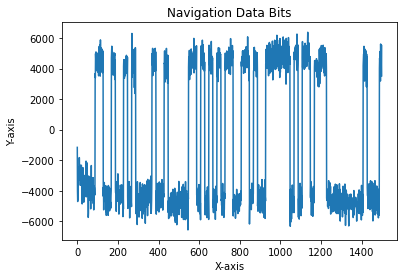

In [82]:
import matplotlib.pyplot as plt
import numpy as np
 
 
# Define X and Y variable data
x = np.arange(1500)
y = np.array(I_P_list)
 
plt.plot(x, y)
plt.xlabel("X-axis")  # add X-axis label
plt.ylabel("Y-axis")  # add Y-axis label
plt.title("Navigation Data Bits")  # add title
plt.show()

### Plotting Early, Late and Prompt Correlation Results

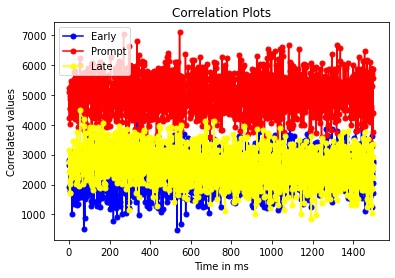

In [83]:
earlyCorrList  = []
promptCorrList = []
lateCorrList   = []

for i in range(1500):
    earlyCorrList.append(math.sqrt(math.pow(I_E_list[i],2)+math.pow(Q_E_list[i],2)))
    promptCorrList.append(math.sqrt(math.pow(I_P_list[i],2)+math.pow(Q_P_list[i],2)))
    lateCorrList.append(math.sqrt(math.pow(I_L_list[i],2)+math.pow(Q_L_list[i],2)))
    
x = np.arange(1500)
y1 = np.array(earlyCorrList)
y2 = np.array(promptCorrList)
y3 = np.array(lateCorrList)

plt.plot(x, y1, color = 'blue', linestyle = 'solid', marker = 'o', markerfacecolor = 'blue', markersize = 5, label="Early")
plt.plot(x, y2, color = 'red', linestyle = 'solid', marker = 'o', markerfacecolor = 'red', markersize = 5, label = "Prompt")
plt.plot(x, y3, color = 'yellow', linestyle = 'solid', marker = 'o', markerfacecolor = 'yellow', markersize = 5, label = "Late")

plt.xlabel("Time in ms")
plt.ylabel("Correlated values")
plt.title('Correlation Plots')
plt.legend()
plt.show()

### I_P Vs Q_P Scatter Plot

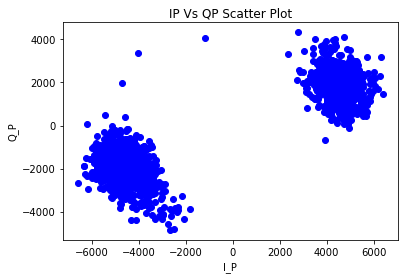

In [84]:
x = np.array(I_P_list)
 
y = np.array(Q_P_list)
 
plt.scatter(x, y, c ="blue")
 
# To show the plot
plt.xlabel("I_P")
plt.ylabel("Q_P")
plt.title('IP Vs QP Scatter Plot')
plt.show()